# Chapter 11 - Deep Network on CIFAR10 Dataset

In [27]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd 
import numpy as np 
import ssl
import matplotlib.pyplot as plt 
from functools import partial 
import os
import math

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [4]:
X_train, y_train, X_valid, y_valid = X_train_full[:40000], y_train_full[:40000], X_train_full[40000:], y_train_full[40000:]

Default DNN Architecture 
- LeCun Initialiation
- ELU Activation

In [61]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

DenseLayer = partial(
    keras.layers.Dense, 
    activation = 'elu',
    kernel_initializer = 'he_normal'
)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(DenseLayer(100))

In [62]:
model.add(keras.layers.Dense(10, activation='softmax'))

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               1

In [14]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('models/ch11_model.h5', save_best_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, 'cifar10_logs', 'run_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [65]:
# default learning rate works alright, but not as good as 5e-5
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=5e-5),
              metrics=["accuracy"])

In [66]:
model.fit(
    X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[callbacks]
)

Epoch 1/100
1250/1250 [==============================] - 18s 12ms/step - loss: 4.7200 - accuracy: 0.1420 - val_loss: 2.2326 - val_accuracy: 0.1847
Epoch 2/100
1250/1250 [==============================] - 16s 13ms/step - loss: 2.1254 - accuracy: 0.2159 - val_loss: 2.0535 - val_accuracy: 0.2408
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.9986 - accuracy: 0.2634 - val_loss: 1.9302 - val_accuracy: 0.2881
Epoch 4/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.9035 - accuracy: 0.3004 - val_loss: 1.8619 - val_accuracy: 0.3117
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.8382 - accuracy: 0.3273 - val_loss: 1.8116 - val_accuracy: 0.3422
Epoch 6/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7964 - accuracy: 0.3431 - val_loss: 1.8478 - val_accuracy: 0.3218
Epoch 7/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7539 - accuracy: 0.3616 - val_loss: 1

In [67]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.5956 - accuracy: 0.4578


[1.5956181287765503, 0.4578000009059906]

Using Batch Normalization 

In [68]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [69]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 batch_normalization (BatchN  (None, 3072)             12288     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               1

In [71]:
# callback method to decrease lr exponentially after 10 epochs
# NOT FOR FINDING OPTIMAL RATE, METHOD OF TRAINING THAT DECREASES LR AS CONVERGENCE BEGINS
def exp_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.1)

In [72]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(exp_scheduler)

In [73]:
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('models/ch11_model_batchnorm.h5', save_best_only=True)
run_logdir = os.path.join(os.curdir, 'cifar10_logs_batchnorm', 'run_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [74]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'] 
)

In [75]:
history = model.fit(
    X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), 
    callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
)

Epoch 1/100
1250/1250 [==============================] - 35s 20ms/step - loss: 1.8483 - accuracy: 0.3365 - val_loss: 1.6725 - val_accuracy: 0.3963
Epoch 2/100
1250/1250 [==============================] - 24s 19ms/step - loss: 1.6730 - accuracy: 0.4025 - val_loss: 1.6088 - val_accuracy: 0.4309
Epoch 3/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.6026 - accuracy: 0.4291 - val_loss: 1.5504 - val_accuracy: 0.4446
Epoch 4/100
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5550 - accuracy: 0.4439 - val_loss: 1.4790 - val_accuracy: 0.4730
Epoch 5/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.5083 - accuracy: 0.4619 - val_loss: 1.4633 - val_accuracy: 0.4716
Epoch 6/100
1250/1250 [==============================] - 23s 19ms/step - loss: 1.4756 - accuracy: 0.4762 - val_loss: 1.4465 - val_accuracy: 0.4893
Epoch 7/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.4425 - accuracy: 0.4877 - val_loss: 1

In [76]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.4547 - accuracy: 0.5254


[1.4547209739685059, 0.5253999829292297]

Batch Norm and Convolutions 

In [84]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [85]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [87]:
# same learning rate with conv layers?
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']
)

In [88]:
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('models/ch11_model_batchnorm_conv.h5', save_best_only=True)
run_logdir = os.path.join(os.curdir, 'cifar10_logs_batchnorm_conv', 'run_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [89]:
conv_hisotry = model.fit(
    X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
)

Epoch 1/100
1250/1250 [==============================] - 43s 28ms/step - loss: 1.7685 - accuracy: 0.3529 - val_loss: 1.7412 - val_accuracy: 0.3642
Epoch 2/100
1250/1250 [==============================] - 35s 28ms/step - loss: 1.4785 - accuracy: 0.4668 - val_loss: 1.4275 - val_accuracy: 0.4948
Epoch 3/100
1250/1250 [==============================] - 34s 27ms/step - loss: 1.3685 - accuracy: 0.5109 - val_loss: 1.7144 - val_accuracy: 0.4442
Epoch 4/100
1250/1250 [==============================] - 35s 28ms/step - loss: 1.2860 - accuracy: 0.5414 - val_loss: 1.3042 - val_accuracy: 0.5419
Epoch 5/100
1250/1250 [==============================] - 35s 28ms/step - loss: 1.2132 - accuracy: 0.5699 - val_loss: 1.1431 - val_accuracy: 0.5977
Epoch 6/100
1250/1250 [==============================] - 34s 28ms/step - loss: 1.1508 - accuracy: 0.5929 - val_loss: 1.6163 - val_accuracy: 0.4944
Epoch 7/100
1250/1250 [==============================] - 35s 28ms/step - loss: 1.1079 - accuracy: 0.6090 - val_loss: 1

In [90]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 1.0585 - accuracy: 0.6794


[1.0584701299667358, 0.6794000267982483]

Add dropout to model

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='lecun_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('selu'))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 64)        

In [11]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']
)

In [15]:
run_index = 1
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('models/ch11_model_batchnorm_conv_dropout.h5', save_best_only=True)
run_logdir = os.path.join(os.curdir, 'cifar10_logs_batchnorm_conv_dropout', 'run_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [17]:
history = model.fit(
    X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
)

Epoch 1/100
1250/1250 [==============================] - 42s 27ms/step - loss: 1.8669 - accuracy: 0.3314 - val_loss: 1.5860 - val_accuracy: 0.4210
Epoch 2/100
1250/1250 [==============================] - 32s 25ms/step - loss: 1.5683 - accuracy: 0.4399 - val_loss: 1.5094 - val_accuracy: 0.4649
Epoch 3/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.4502 - accuracy: 0.4866 - val_loss: 1.5229 - val_accuracy: 0.4927
Epoch 4/100
1250/1250 [==============================] - 30s 24ms/step - loss: 1.3633 - accuracy: 0.5201 - val_loss: 2.0071 - val_accuracy: 0.3987
Epoch 5/100
1250/1250 [==============================] - 30s 24ms/step - loss: 1.2896 - accuracy: 0.5467 - val_loss: 1.4177 - val_accuracy: 0.5114
Epoch 6/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.2211 - accuracy: 0.5716 - val_loss: 1.3271 - val_accuracy: 0.5478
Epoch 7/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.1788 - accuracy: 0.5887 - val_loss: 1

In [18]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 1.0986 - accuracy: 0.7021


[1.0986346006393433, 0.7020999789237976]

MC Dropout

In [19]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [20]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [22]:
def mc_dropout_predict_probs(mc_model, X, n_samples=10):
    Y_probs = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probs, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probs = mc_dropout_predict_probs(mc_model, X, n_samples)
    return np.argmax(Y_probs, axis=1)

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.7014

1cycle Scheduling

In [29]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [32]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='lecun_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('selu'))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

In [26]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(
    loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']
)

313/313 [==============================] - 20s 53ms/step - loss: 14.3551 - accuracy: 0.1330


(9.999999747378752e-06,
 9.568211555480957,
 2.7706503868103027,
 4.27955116544451)

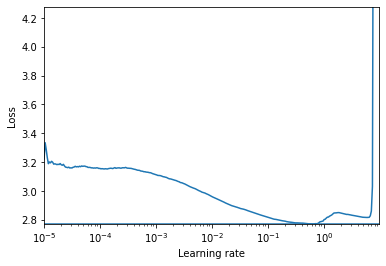

In [30]:
batch_size=128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [31]:
# lr = 1e-2
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(
    loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']
)

In [33]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(
    X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[onecycle]
)

Epoch 1/15
313/313 [==============================] - 23s 63ms/step - loss: 2.1540 - accuracy: 0.2566 - val_loss: 2.1726 - val_accuracy: 0.2327
Epoch 2/15
313/313 [==============================] - 21s 66ms/step - loss: 1.7346 - accuracy: 0.3821 - val_loss: 2.0433 - val_accuracy: 0.3414
Epoch 3/15
313/313 [==============================] - 21s 66ms/step - loss: 1.5544 - accuracy: 0.4472 - val_loss: 2.0232 - val_accuracy: 0.3317
Epoch 4/15
313/313 [==============================] - 21s 66ms/step - loss: 1.4420 - accuracy: 0.4906 - val_loss: 1.7491 - val_accuracy: 0.4096
Epoch 5/15
313/313 [==============================] - 21s 69ms/step - loss: 1.3507 - accuracy: 0.5229 - val_loss: 2.6748 - val_accuracy: 0.2927
Epoch 6/15
313/313 [==============================] - 21s 69ms/step - loss: 1.2806 - accuracy: 0.5483 - val_loss: 1.8825 - val_accuracy: 0.3849
Epoch 7/15
313/313 [==============================] - 21s 67ms/step - loss: 1.2293 - accuracy: 0.5705 - val_loss: 1.7696 - val_accuracy:

In [34]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.0539 - accuracy: 0.6500


[1.0538513660430908, 0.6499999761581421]